### Imports:

In [ ]:
!pip install hdbscan
!pip install sentence-transformers
!pip install umap-learn
!pip install mplcursors

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

from hdbscan import HDBSCAN
from sklearn.cluster import DBSCAN

from sklearn import metrics
from tqdm.notebook import trange


from sentence_transformers import SentenceTransformer
import umap
import mplcursors

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os

In [4]:
from transformers import BertTokenizer, BertModel

#### Loading Data:

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

## Creating Embeddings on Utterance Level using BERT, BERT Banking and TF-IDF:

### Create BERT Uncased Embeddings on Utterance Level:

In [ ]:
BERT_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
BERT_model = BertModel.from_pretrained('bert-base-uncased')

In [7]:
def get_bert_embeddings(sentence):
    inputs = BERT_tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = BERT_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT_embeddings'] = test['text'].apply(get_bert_embeddings)
test

,text,category,BERT_embeddings
0,How do I locate my card?,card_arrival,"[0.11946714, 0.0462514, 0.07216076, -0.0717430..."
1,"I still have not received my new card, I order...",card_arrival,"[0.1455653, -0.17301682, 0.396418, 0.20625193,..."
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[-0.050330862, -0.2557014, 0.44595417, -0.0304..."
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.044740878, -0.3670077, 0.41925043, 0.03467..."
4,My card has not arrived yet.,card_arrival,"[0.3028919, -0.22428086, 0.10192727, -0.203572..."
...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.49874625, -0.046890993, 0.43037665, -0.3773..."
3076,How many countries do you support?,country_support,"[0.4169197, -0.19576609, 0.10278029, -0.101284..."
3077,What countries do you do business in?,country_support,"[0.43335438, -0.14970121, -0.07299802, -0.2744..."
3078,What are the countries you operate in.,country_support,"[0.26136342, -0.20304756, -0.15264143, -0.1744..."


### Create TF-IDF Embeddings on Utterance Level:

In [23]:
tfidf_vectorizer = TfidfVectorizer(min_df=15, max_df=0.85, ngram_range=(1, 2))

In [28]:
X_tfidf = tfidf_vectorizer.fit_transform(test['text'])
test['TF_IDF_embeddings'] = list(X_tfidf.toarray())

### Create BERT Banking Embeddings on Utterance Level:

In [29]:
BERT_bank_tokenizer = BertTokenizer.from_pretrained('philschmid/BERT-Banking77')
BERT_bank_model = BertModel.from_pretrained('philschmid/BERT-Banking77')

tokenizer_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/5.95k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [33]:
def get_bert_banking_embeddings(sentence):
    inputs = BERT_bank_tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
    outputs = BERT_bank_model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()
    return embeddings

# Apply the function to each utterance
test['BERT77_embeddings'] = test['text'].apply(get_bert_banking_embeddings)
test

,text,category,BERT_embeddings,TF_IDF_embeddings,BERT77_embeddings
0,How do I locate my card?,card_arrival,"[0.11946714, 0.0462514, 0.07216076, -0.0717430...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.42865202, -0.43469578, 0.3052942, 0.2347375..."
1,"I still have not received my new card, I order...",card_arrival,"[0.1455653, -0.17301682, 0.396418, 0.20625193,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.16829188, 0.09822858, 1.3819345, -0.1845505..."
2,I ordered a card but it has not arrived. Help ...,card_arrival,"[-0.050330862, -0.2557014, 0.44595417, -0.0304...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.12018974, -0.12311054, 1.4518343, 0.2730053..."
3,Is there a way to know when my card will arrive?,card_arrival,"[-0.044740878, -0.3670077, 0.41925043, 0.03467...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.15183571, 0.082956925, 1.4436911, 0.078706..."
4,My card has not arrived yet.,card_arrival,"[0.3028919, -0.22428086, 0.10192727, -0.203572...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.24080856, 0.40944988, 1.2567027, -0.2404651..."
...,...,...,...,...,...
3075,"If i'm not in the UK, can I still get a card?",country_support,"[0.49874625, -0.046890993, 0.43037665, -0.3773...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.27429864, -0.82551634, 0.25383866, 0.810523..."
3076,How many countries do you support?,country_support,"[0.4169197, -0.19576609, 0.10278029, -0.101284...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.3326514, -0.5459342, 0.062237754, 0.7839224..."
3077,What countries do you do business in?,country_support,"[0.43335438, -0.14970121, -0.07299802, -0.2744...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.4262836, -0.46747416, 0.20949411, 0.7919105..."
3078,What are the countries you operate in.,country_support,"[0.26136342, -0.20304756, -0.15264143, -0.1744...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.41575032, -0.5905341, 0.29422665, 0.8811767..."


## Dimension Reduction (UMAP) and Clustering:

### Performing Random Search to Identify the Best Parameters:

In [72]:

def create_clusters(embeddings, n_neighbors, n_components, min_cluster_size, min_samples = None, random_state = None):

    umap_embeddings = (umap.UMAP(n_neighbors = n_neighbors, n_components = n_components, metric = 'cosine', random_state=random_state).fit_transform(embeddings))

    clusters = HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_samples, gen_min_span_tree=True, cluster_selection_method='eom').fit(umap_embeddings)

    return clusters

In [76]:
def score_clusters(cluster, prob_threshold = 0.5):
  count = 0
  for prob in cluster.probabilities_:
    if prob < prob_threshold and prob != 0:
      count += 1
  label_count = len(np.unique(cluster.labels_))
  score = count/len(cluster.labels_)

  return label_count, score

In [89]:
def random_search(embeddings, space, num_evals):

    results = []

    for i in trange(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])
        random_state = space['random_state']

        clusters = create_clusters(embeddings,
                                     n_neighbors=n_neighbors,
                                     n_components=n_components,
                                     min_cluster_size=min_cluster_size,
                                     random_state=random_state)

        label_count, cost = score_clusters(clusters, prob_threshold = 0.5)

        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])
        print(results)

    result_df = pd.DataFrame(results, columns=['run_id', 'n_neighbors', 'n_components',
                                               'min_cluster_size', 'label_count', 'cost'])

    return result_df.sort_values(by='cost')

In [90]:
%%time
bert77_embeddings = np.vstack(test['BERT77_embeddings'].to_numpy())

space = {
        "n_neighbors": range(5,15),
        "n_components": range(5,15),
        "min_cluster_size": range(60,100),
        "random_state": 42
    }

random_use = random_search(bert77_embeddings, space, 15)


  0%|          | 0/15 [00:00<?, ?it/s]

[[0, 14, 6, 72, 22, 0.039285714285714285]]
[[0, 14, 6, 72, 22, 0.039285714285714285], [1, 5, 6, 72, 20, 0.018506493506493506]]
[[0, 14, 6, 72, 22, 0.039285714285714285], [1, 5, 6, 72, 20, 0.018506493506493506], [2, 10, 5, 71, 23, 0.05974025974025974]]
[[0, 14, 6, 72, 22, 0.039285714285714285], [1, 5, 6, 72, 20, 0.018506493506493506], [2, 10, 5, 71, 23, 0.05974025974025974], [3, 10, 8, 88, 12, 0.05422077922077922]]
[[0, 14, 6, 72, 22, 0.039285714285714285], [1, 5, 6, 72, 20, 0.018506493506493506], [2, 10, 5, 71, 23, 0.05974025974025974], [3, 10, 8, 88, 12, 0.05422077922077922], [4, 11, 7, 77, 19, 0.0775974025974026]]
[[0, 14, 6, 72, 22, 0.039285714285714285], [1, 5, 6, 72, 20, 0.018506493506493506], [2, 10, 5, 71, 23, 0.05974025974025974], [3, 10, 8, 88, 12, 0.05422077922077922], [4, 11, 7, 77, 19, 0.0775974025974026], [5, 8, 12, 66, 21, 0.11493506493506493]]
[[0, 14, 6, 72, 22, 0.039285714285714285], [1, 5, 6, 72, 20, 0.018506493506493506], [2, 10, 5, 71, 23, 0.05974025974025974], [3, 

In [93]:
parametersList = [[0, 14, 6, 72, 22, 0.039285714285714285], [1, 5, 6, 72, 20, 0.018506493506493506], [2, 10, 5, 71, 23, 0.05974025974025974], [3, 10, 8, 88, 12, 0.05422077922077922], [4, 11, 7, 77, 19, 0.0775974025974026], [5, 8, 12, 66, 21, 0.11493506493506493], [6, 8, 14, 62, 24, 0.06753246753246753], [7, 14, 8, 79, 17, 0.11396103896103896], [8, 6, 10, 93, 14, 0.08538961038961039], [9, 7, 10, 81, 17, 0.11233766233766233], [10, 9, 11, 68, 22, 0.0762987012987013], [11, 5, 10, 77, 17, 0.09902597402597403], [12, 5, 14, 94, 10, 0.06915584415584415], [13, 7, 8, 87, 13, 0.02564935064935065], [14, 9, 11, 93, 12, 0.02792207792207792]]
result_df = pd.DataFrame(parametersList, columns=['run_id', 'n_neighbors', 'n_components','min_cluster_size', 'label_count', 'cost'])
result_df.sort_values(by='cost')

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
1,1,5,6,72,20,0.018506
13,13,7,8,87,13,0.025649
14,14,9,11,93,12,0.027922
0,0,14,6,72,22,0.039286
3,3,10,8,88,12,0.054221
2,2,10,5,71,23,0.059740
6,6,8,14,62,24,0.067532
12,12,5,14,94,10,0.069156
10,10,9,11,68,22,0.076299
4,4,11,7,77,19,0.077597


### HDBSCAN Clustering using BERT77 Embeddings (with best parameters):

In [97]:
bert77_embeddings = np.vstack(test['BERT77_embeddings'].to_numpy())
umap_bert77 = umap.UMAP(n_neighbors=5, n_components=6, metric='cosine', random_state=42).fit_transform(bert77_embeddings)

In [98]:
hdbscan_bert77 = HDBSCAN(min_cluster_size=72, gen_min_span_tree=True, cluster_selection_method='eom')
test["topic"] = hdbscan_bert77.fit_predict(umap_bert77)
np.unique(hdbscan_bert77.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18])

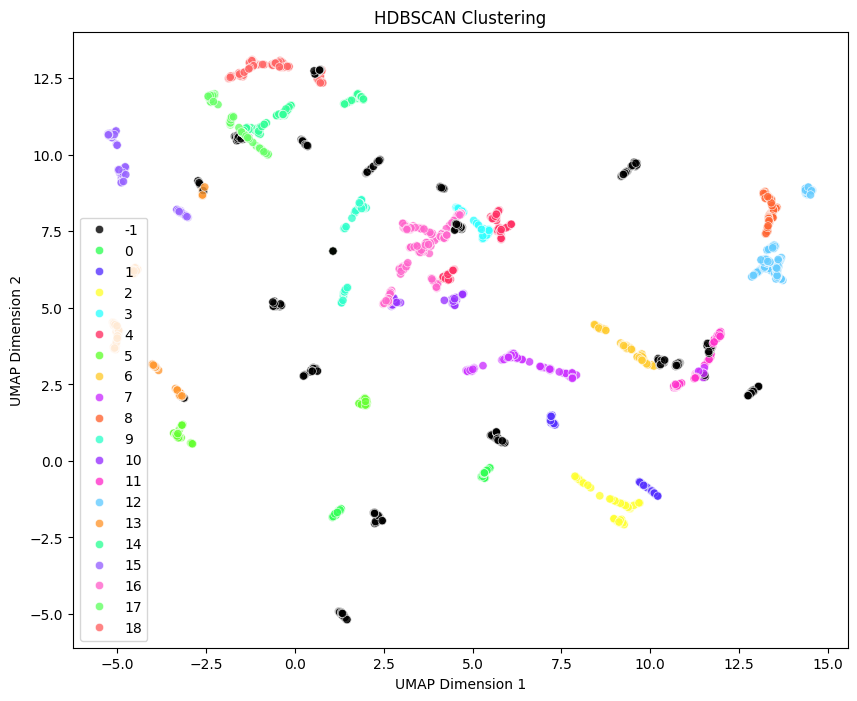

In [100]:
custom_colors = [
    '#000000', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF3366', '#66FF33', '#FFCC33', '#CC33FF',
    '#FF6633', '#33FFCC', '#9933FF', '#FF33CC', '#66CCFF',
    '#FF9933', '#33FF99', '#9966FF', '#FF66CC', '#66FF66',
    '#FF6666', '#66CC66', '#CC66FF', '#FF9966', '#66FFCC', '#FFCC66'
]
custom_palette = sns.color_palette(custom_colors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_bert77[:, 0], y=umap_bert77[:, 1], hue=test["topic"], legend='full', alpha=0.8, palette=custom_palette)
plt.title('HDBSCAN Clustering')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

#### For each cluster, output the unique categories in that cluster, and their respective count:

In [101]:
cluster_info = {}
for i in np.unique(hdbscan_bert77.labels_):
  rah = test[test["topic"]== i]
  value_counts = rah["category"].value_counts()

  category_info = {}
  for index, count in value_counts.items():
    if count > 3:
      category_info[index] = count

  cluster_info[i] = category_info

cluster_info

{-1: {'request_refund': 40,
  'passcode_forgotten': 40,
  'age_limit': 40,
  'verify_top_up': 40,
  'verify_source_of_funds': 40,
  'Refund_not_showing_up': 40,
  'edit_personal_details': 40,
  'activate_my_card': 39,
  'top_up_by_card_charge': 39,
  'pending_cash_withdrawal': 39,
  'visa_or_mastercard': 37,
  'exchange_charge': 37,
  'wrong_amount_of_cash_received': 36,
  'pin_blocked': 34,
  'declined_transfer': 29,
  'apple_pay_or_google_pay': 20,
  'direct_debit_payment_not_recognised': 6,
  'get_disposable_virtual_card': 4},
 0: {'lost_or_stolen_phone': 39, 'disposable_card_limits': 34},
 1: {'extra_charge_on_statement': 40, 'card_payment_fee_charged': 39},
 2: {'atm_support': 39,
  'cash_withdrawal_charge': 39,
  'wrong_exchange_rate_for_cash_withdrawal': 34},
 3: {'card_about_to_expire': 40, 'contactless_not_working': 38},
 4: {'getting_spare_card': 39,
  'order_physical_card': 38,
  'card_swallowed': 37},
 5: {'get_physical_card': 39, 'change_pin': 39, 'pin_blocked': 4},
 6: {'

### HDBSCAN on BERT embeddings:

#### Random Search for Parameters:

In [112]:
%%time
bert_embeddings = np.vstack(test['BERT_embeddings'].to_numpy())

space = {
        "n_neighbors": range(5,15),
        "n_components": range(5,12),
        "min_cluster_size": range(10,25),
        "random_state": 42
    }

random_use = random_search(bert_embeddings, space, 15)

  0%|          | 0/15 [00:00<?, ?it/s]

[[0, 5, 10, 23, 21, 0.00909090909090909]]
[[0, 5, 10, 23, 21, 0.00909090909090909], [1, 11, 7, 18, 3, 0.003246753246753247]]
[[0, 5, 10, 23, 21, 0.00909090909090909], [1, 11, 7, 18, 3, 0.003246753246753247], [2, 13, 10, 24, 3, 0.003246753246753247]]
[[0, 5, 10, 23, 21, 0.00909090909090909], [1, 11, 7, 18, 3, 0.003246753246753247], [2, 13, 10, 24, 3, 0.003246753246753247], [3, 12, 9, 17, 3, 0.002922077922077922]]
[[0, 5, 10, 23, 21, 0.00909090909090909], [1, 11, 7, 18, 3, 0.003246753246753247], [2, 13, 10, 24, 3, 0.003246753246753247], [3, 12, 9, 17, 3, 0.002922077922077922], [4, 6, 9, 21, 5, 0.010064935064935065]]
[[0, 5, 10, 23, 21, 0.00909090909090909], [1, 11, 7, 18, 3, 0.003246753246753247], [2, 13, 10, 24, 3, 0.003246753246753247], [3, 12, 9, 17, 3, 0.002922077922077922], [4, 6, 9, 21, 5, 0.010064935064935065], [5, 9, 8, 18, 24, 0.015909090909090907]]
[[0, 5, 10, 23, 21, 0.00909090909090909], [1, 11, 7, 18, 3, 0.003246753246753247], [2, 13, 10, 24, 3, 0.003246753246753247], [3, 12

In [114]:
parametersList2 = [[0, 5, 10, 23, 21, 0.00909090909090909], [1, 11, 7, 18, 3, 0.003246753246753247], [2, 13, 10, 24, 3, 0.003246753246753247], [3, 12, 9, 17, 3, 0.002922077922077922], [4, 6, 9, 21, 5, 0.010064935064935065], [5, 9, 8, 18, 24, 0.015909090909090907], [6, 5, 5, 13, 49, 0.05097402597402598], [7, 8, 11, 12, 41, 0.03214285714285714], [8, 11, 9, 24, 3, 0.0035714285714285713], [9, 11, 11, 13, 3, 0.002922077922077922], [10, 10, 11, 19, 3, 0.003246753246753247], [11, 13, 8, 23, 3, 0.0012987012987012987], [12, 8, 9, 24, 5, 0.0042207792207792205], [13, 6, 5, 21, 22, 0.012337662337662338], [14, 10, 5, 19, 3, 0.002922077922077922]]
result_df2 = pd.DataFrame(parametersList2, columns=['run_id', 'n_neighbors', 'n_components','min_cluster_size', 'label_count', 'cost'])
result_df2.sort_values(by='cost')

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
11,11,13,8,23,3,0.001299
3,3,12,9,17,3,0.002922
9,9,11,11,13,3,0.002922
14,14,10,5,19,3,0.002922
1,1,11,7,18,3,0.003247
2,2,13,10,24,3,0.003247
10,10,10,11,19,3,0.003247
8,8,11,9,24,3,0.003571
12,12,8,9,24,5,0.004221
0,0,5,10,23,21,0.009091


#### Clustering and Plotting:

In [116]:
bert_embeddings = np.vstack(test['BERT_embeddings'].to_numpy())
umap_bert = umap.UMAP(n_neighbors=5, n_components=10, metric='cosine').fit_transform(bert_embeddings)

In [117]:
hdbscan_bert = HDBSCAN(min_cluster_size=23)
test["topic_BERT"] = hdbscan_bert.fit_predict(umap_bert)
np.unique(hdbscan_bert.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19])

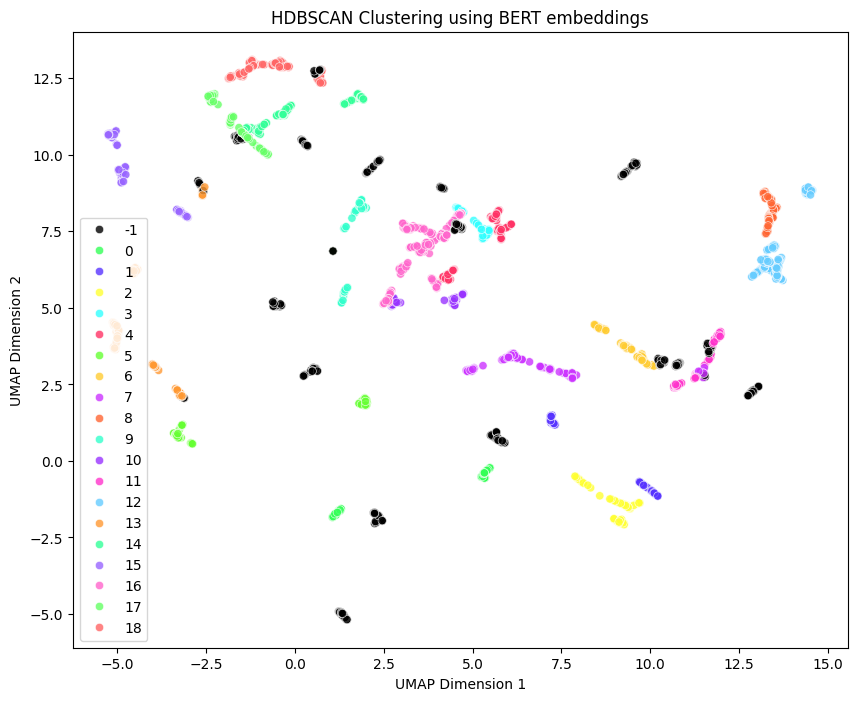

In [118]:
custom_colors = [
    '#000000', '#33FF57', '#5733FF', '#FFFF33', '#33FFFF',
    '#FF3366', '#66FF33', '#FFCC33', '#CC33FF',
    '#FF6633', '#33FFCC', '#9933FF', '#FF33CC', '#66CCFF',
    '#FF9933', '#33FF99', '#9966FF', '#FF66CC', '#66FF66',
    '#FF6666', '#66CC66', '#CC66FF', '#FF9966', '#66FFCC', '#FFCC66'
]
custom_palette = sns.color_palette(custom_colors)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=umap_bert77[:, 0], y=umap_bert77[:, 1], hue=test["topic"], legend='full', alpha=0.8, palette=custom_palette)
plt.title('HDBSCAN Clustering using BERT embeddings')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.show()

#### For each cluster, output the unique categories in that cluster, and their respective count:

In [119]:
cluster_info = {}
for i in np.unique(hdbscan_bert.labels_):
  rah = test[test["topic_BERT"]== i]
  value_counts = rah["category"].value_counts()

  category_info = {}
  for index, count in value_counts.items():
    if count > 3:
      category_info[index] = count

  cluster_info[i] = category_info

cluster_info

{-1: {'request_refund': 31,
  'beneficiary_not_allowed': 31,
  'cancel_transfer': 29,
  'card_arrival': 27,
  'lost_or_stolen_phone': 25,
  'declined_transfer': 25,
  'lost_or_stolen_card': 24,
  'declined_card_payment': 24,
  'reverted_card_payment?': 23,
  'cash_withdrawal_not_recognised': 23,
  'wrong_amount_of_cash_received': 22,
  'declined_cash_withdrawal': 22,
  'card_swallowed': 22,
  'exchange_via_app': 21,
  'top_up_by_cash_or_cheque': 21,
  'card_delivery_estimate': 20,
  'transaction_charged_twice': 19,
  'extra_charge_on_statement': 19,
  'edit_personal_details': 19,
  'get_physical_card': 19,
  'pending_card_payment': 19,
  'transfer_not_received_by_recipient': 18,
  'Refund_not_showing_up': 18,
  'card_payment_not_recognised': 18,
  'contactless_not_working': 18,
  'topping_up_by_card': 17,
  'failed_transfer': 16,
  'transfer_into_account': 16,
  'receiving_money': 15,
  'balance_not_updated_after_cheque_or_cash_deposit': 15,
  'activate_my_card': 15,
  'pending_transfe